Part 1
First I will import necessary libraries for the assignment.


In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_fscore_support
from scipy import ndimage
from skimage import measure

In [2]:
def imshow_fcn(img,title='',cmap='gray',save=False):
    plt.figure()
    plt.imshow(img,cmap=cmap)
    plt.axis('off')
    plt.title(title)
    if save :
        plt.savefig(title+'.png')
    plt.show()

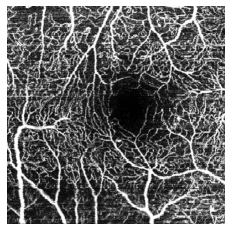

In [3]:
img_id = '0-2SVP_original.png'

def load_image(img_id):
    ROSE_PATH = 'data/ROSE-2/train'
    image_file = f'{ROSE_PATH}/original/{img_id}'
    image_mask_file = f'{ROSE_PATH}/gt/{img_id}'

    img=cv2.imread(image_file)
    img_mask = cv2.imread(image_mask_file)[:,:,0]/255.0

    assert img_mask.max() == 1.0

    return img,img_mask

img,img_mask = load_image(img_id)
imshow_fcn(img,cmap='jet')



In [4]:

def find_foreground(img,closing_kernel_size=7,filter_kernel_size=3):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    hpf = -1*np.ones((filter_kernel_size,filter_kernel_size))
    kernel_center = filter_kernel_size//2
    hpf[kernel_center,kernel_center]=filter_kernel_size**2-1
    img_filt = cv2.filter2D(img_gray,-1,hpf)

    kernel = np.ones((closing_kernel_size,closing_kernel_size))
    img_dilation = cv2.dilate(img_filt, kernel, iterations=7)
    img_erosion = cv2.erode(img_dilation, kernel, iterations=7)
    ret2,img_thr = cv2.threshold(img_erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    print(f'Otsu Thr : {ret2:.3f}')
    return img_thr/255

def find_foreground_blur(img,kernel_size=5,closing_kernel_size = 5):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img_gray,(kernel_size,kernel_size),0)

    kernel = np.ones((closing_kernel_size,closing_kernel_size))
    img_dilation = cv2.dilate(blur, kernel, iterations=3)
    img_erosion = cv2.erode(img_dilation, kernel, iterations=3)
    ret3,th3 = cv2.threshold(img_erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3/255

def find_foreground_closing(img,kernel_size=5,closing_kernel_size = 5,num_iter=7):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

    kernel = np.ones((closing_kernel_size,closing_kernel_size))
    # img_dilation = cv2.dilate(blur, kernel, iterations=3)
    # img_erosion = cv2.erode(img_dilation, kernel, iterations=3)
    ret3,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img=ndimage.binary_closing(img,kernel,iterations=num_iter)
    return img.astype(int)


In [5]:
def find_foreground_hpf_closing(img,kernel_size=3,num_iter=7):

    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    img=cv2.filter2D(img,-1,filter)

    bil=cv2.bilateralFilter(img,9,75,75)
    gray = cv2.cvtColor(bil,cv2.COLOR_BGR2GRAY)
    _, img_otsu = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.imshow(img_otsu, cmap='gray')
    plt.axis('off')
    image_bc=ndimage.binary_closing(img_otsu,np.ones((3,3)),iterations=num_iter)

    return image_bc.astype(int)

def calculate_stats(img,img_pred,disp=False):
    precision,recall,f1score,_= precision_recall_fscore_support(img.flatten(), img_pred.flatten(), average='binary')
    if disp:
        print(f'F1 Score : {f1score:.4f}')
        print(f'Precision : {precision:.4f}')
        print(f'Recall : {recall:.4f}')

    return f1score
    

In [ ]:

import os
img_ids = [img for img in os.listdir('data/ROSE-2/train/original/') if img.endswith('.png')]
for img_id in img_ids:
    img,img_mask = load_image(img_id)
    best_score=0
    best_iter=2
    for num_iter in range(2,30):
        img_thr = find_foreground_hpf_closing(img,kernel_size=3,num_iter=num_iter)
        f1score = calculate_stats(img_mask,img_thr)
        if f1score >best_score:
            best_score=f1score
            best_iter=num_iter
            print(f'Best Score : {best_score:.3f} for {best_iter} iterations')
    img_thr = find_foreground_hpf_closing(img,kernel_size=3,num_iter=best_iter)
    f1score = calculate_stats(img_mask,img_thr,disp=True)
    print(f'Image_{img_id}')
    imshow_fcn(img_thr,title=f'Image_{img_id}_foreground_iter_{best_iter}',save=True)



Part 2

In [6]:
from sklearn.cluster import KMeans
from skimage import measure
from skimage.feature import peak_local_max


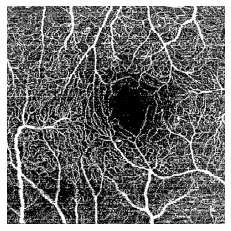

In [7]:
img_id = '0-2SVP_original.png'
img,img_mask = load_image(img_id)
my_mask = find_foreground_hpf_closing(img,kernel_size=3,num_iter=7)

In [8]:
def visualize_intermediate_features(thresh_img,difference,closing_img,dist_transform,title='',save=False):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    axs[0,0].imshow(thresh_img,cmap='gray')
    axs[0,0].set_title('Threshold Image')
    axs[0,0].axis('off')

    axs[0,1].imshow(difference,cmap='gray')
    axs[0,1].set_title('Difference')
    axs[0,1].axis('off')


    axs[1,0].imshow(closing_img,cmap='gray')
    axs[1,0].set_title('Closing Image')
    axs[1,0].axis('off')

    axs[1,1].imshow(dist_transform,cmap='gray')
    axs[1,1].set_title('Distance Transform')
    axs[1,1].axis('off')
    plt.suptitle(title)
    if save:
        plt.savefig(title+'.png')
    plt.show()

def save_dist_maps(original_img ,dist_transform,title=''):
    fig, axs = plt.subplots(1, 2, figsize=(10, 7))
    axs[0].imshow(original_img,cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(dist_transform,cmap='gray')
    axs[1].set_title('Distance Transform')
    axs[1].axis('off')
    plt.suptitle(title)
    plt.savefig(title+'.png')

def find_cell_locations(img,n_cluster=200,title='',visual_intermediate=True):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    my_mask = find_foreground_hpf_closing(img,kernel_size=3,num_iter=7)

    difference=np.subtract((255*my_mask),img_otsu)
    difference[difference<255]=0
    

    kernel = np.ones((3,3),np.uint8)
    closing_img=ndimage.binary_closing(difference,kernel,iterations=1)


    closing_img = closing_img.astype(np.uint8)
    dist_transform = cv2.distanceTransform(closing_img, cv2.DIST_L2, 3)

    if visual_intermediate:
        visualize_intermediate_features(img_otsu,difference,closing_img,dist_transform,title=title,save=False)
    save_dist_maps(img,dist_transform,title=title)

    local_maxima = peak_local_max(dist_transform, min_distance=1)
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(local_maxima)
    local_maxima = kmeans.cluster_centers_.copy().astype(int)

    
    if visual_intermediate:
        dist_transform_copy = dist_transform.copy()
        for i in range(local_maxima.shape[0]):
            cv2.circle( dist_transform_copy, (local_maxima[i][1],local_maxima[i][0] ), 5, 255)
        plt.imshow(dist_transform_copy)
        plt.axis('off')
        plt.show()

    return dist_transform, local_maxima


In [ ]:
img_ids = [img for img in os.listdir('data/ROSE-2/train/original/') if img.endswith('.png')]
for i, img_id in enumerate(img_ids):
    img,img_mask = load_image(img_id)
    title=f'ROSE-2-New-Results/Image_{img_id[:-4]}_cell_loc'
    dist_transform, local_max_location = find_cell_locations(img,n_cluster=200,title=title,visual_intermediate=False)
    print(f'{i}/{len(img_ids)}')